# Impact of the Thomas Fire on Santa Barbara County Air Quality and Land Cover Change
Author: Heather Childers

*For more information and a complete workflow with extra checks, consider checking out my github repositiory!*
**Github Repo:** https://github.com/hmchilders/ThomasFire_AQI

## About this Notebook:
The purpose of this exercise is to explore the impact of the 2017 Thomas fire on Santa Barbara County air quality and land cover. We'll analyze the impact on air quality by plotting the daily and 5-day rolling average values of the air quality index for 2017 and 2018 to compare the AQI during the Thomas fire to the usual AQI for the area. We'll explore the land cover change by using a false color image of Santa Barbara County and comparing it with the fire scar from the Thomas Fire.

Some highlights of this analysis include:
- Fetching data from an online repository
- Data wrangling
- Time Series analysis
- Creating line plots with a legend
- Creating a false color image
- Visulaizing raster data

## About the data:
We'll be using the following Datasets for this analysis:

1. Air Quality Index (AQI) data from the US Environmental Protection Agency to visualize the impact on the AQI of the 2017 Thomas Fire in Santa Barbara County.
The data can be accesses here: “AirData Website File Download Page.” EPA, Environmental Protection Agency, aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023. 

2. A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.
The data can be accessed in the data folder of this repository. More info can be found here: “Microsoft Planetary Computer.” Planetary Computer, planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.  

3. A shapefile of fire perimeters in California during 2017
The data can be accessed here: “California Fire Perimeters (All).” California State Geoportal, California Department of Forestry and Fire Protection, gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023. 


These are the plots we'll be trying to make:
A timeseries analysis showing the daily average AQI and the 5-day rolling average from 2017 to 2018. 

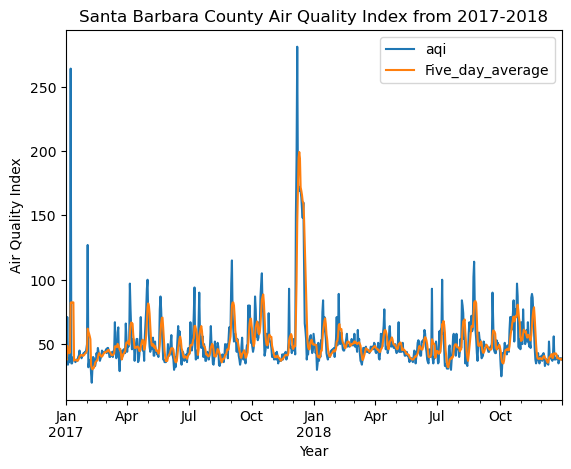

A false color image showing the fire scar from the Thomas fire in Santa Barbara County

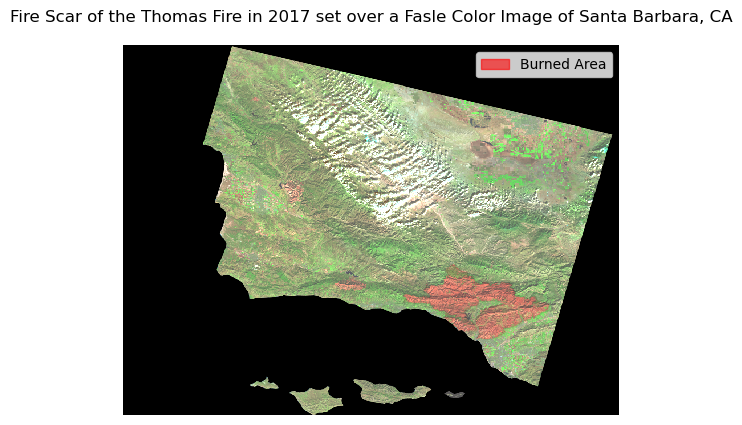

## Import Libraries
For this exercise, we'll be using a variety of python packages. Please install these packages as needed before you import them.

In [10]:
#Import the libraries and functions needed for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from shapely import Point
from shapely.geometry import box
from rasterio.features import rasterize 

# Plot 1: Daily and 5-day Rolling Average AQI for 2017-2018
This section has a step by step walkthrough of the steps needed to create the first plot in this analysis 
### Import Data
Load in the 2 AQI datasets will be used for the first plot showing AQI over time:

In [11]:
# read in the 2017 AQI data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

# read in the 2018 AQI data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')


### Prepare and Explore the AQI Data
To prepare the AQI Data, we will preform the following steps: 
1. Create one dataset to work with by concatenating the data
2. Clean the Data so that it is easier to wrangle

When you're done preparing the data, use the `.head()` function to check that our data preparations are successful. This is also useful for knowing how we will subset the data in the next step.

In [24]:
# Concatenate 2 dataframes
aqi = pd.concat([aqi_17,aqi_18])

#-----Clean the Data-----
# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')
#Use .head()to see the head of the dataframe 
aqi.head(n=3)

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1


### Select only the SB County data and the relevant columns
The AQI dataframe has a lot of data that won't be necessary for our analysis. The first step of this process is to filter the columns to only keep the observations from Santa Barbara County. The second step is to slect only the necessary columns from the dataframe. 
Shown below is the subsetting performed in one line:

In [13]:
# Use df.loc to filter to the Santa Barbara rows and columns
aqi_sb = aqi.loc[aqi.county_name == 'Santa Barbara',
                 ['date', 'aqi', 'category','defining_parameter', 'defining_site', 'number_of_sites_reporting']]
#

### Wrangle the Data before Plotting
In this analysis, we are looking to plot both the daily averages for the AQI as well as the five day rolling averages. Before we plot the data it is important that we first perform the necessary data wrangling to:
1. Set the date to a datetime object
2. Set the date as the index
3. Calculate the 5 day rolling average

In [14]:
# Overwrite the current date columns and set the dates to a datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# Use set_index to reset the index 
aqi_sb = aqi_sb.set_index('date')

# access the index
aqi_index = aqi_sb.index

# add the 5 Day Average column
aqi_sb.aqi.rolling('5D').mean()
aqi_sb = aqi_sb.assign(Five_day_average = aqi_sb.aqi.rolling('5D').mean())

## Plot the AQI Data
Use the dataframe we cleaned and wrangled above to plot the Daily and 5_day average AQI data.

Due to the way we cleaned and wrangled the data, we are able to use just the `.plot()` function with some simple customizations to create the desired visualization.

<Axes: title={'center': 'Santa Barbara County Air Quality Index from 2017-2018'}, xlabel='Year', ylabel='Air Quality Index'>

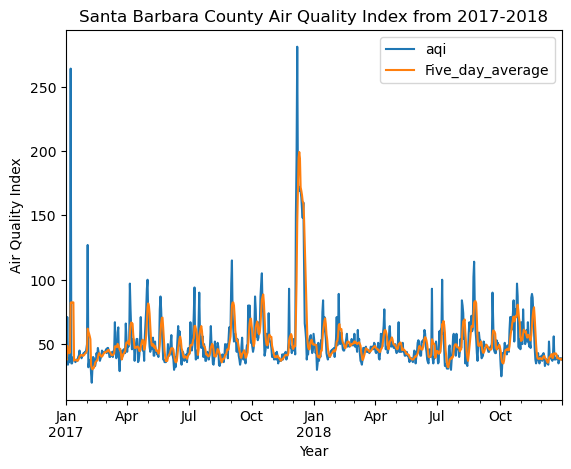

In [15]:
# plot the data
aqi_sb.plot(use_index = True, 
        y= ['aqi', 'Five_day_average'],
        title='Santa Barbara County Air Quality Index from 2017-2018',
        xlabel='Year',
        ylabel='Air Quality Index'
        )

# Plot 2: Plot the Thomas Fire Burn Scar as a False Color Image
The following steps will walkthough how to create the flase color image using the landsat data and the California fire perimeters data.

If youre interested, you can read more about false color images here:
[NASA Earth Observatory - Why is that Forest Red and that Cloud Blue?
How to Interpret a False-Color Satellite Image](https://earthobservatory.nasa.gov/features/FalseColor)

### Import Land Cover Data 
Let's begin by importing the two necessary datasets for this analysis: 

In [16]:
# Import the LandSat8 data
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

# Import the CalFire data
calfire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')

### Clean and Wrangle the CALFIRE Data
Before we create the visualization, there are a few steps to clean and wrangle the data to make it easier to work with later. The following code chunk runs through the follwoing steps:
1. Make the column names lowercase
2. Filter the Calfire data to only keep the Thomas Fire Data
3. Reproject the calfire data to the same CRS as the landsat data so that they can be layered when plotting 

In [17]:
# re-assign the column names - .str.lower() makes them lower case
calfire.columns = calfire.columns.str.lower()

#Select only the thomas fire from the calfire data
calfire = calfire[calfire['fire_name'] == 'THOMAS']

# Reproject the calfire data to the landsat CRS
calfire = calfire.to_crs(landsat.rio.crs)

### Create the Thomas Fire Burn Scar
Now that we have cleaned and wrangled the data, we can use the `.plot()` function to plot the burn scar.
You can leave the parentheses empty or add some visual customizations as shown below:

<Axes: >

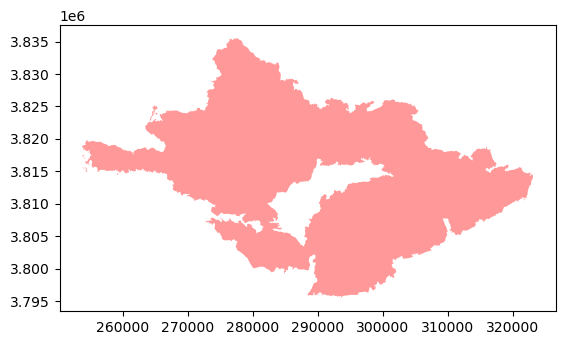

In [23]:
#Plot the CA fire Data
calfire.plot(color = 'red', alpha = 0.4)

### Clean and Wrangle the Landsat Data
This data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). 
The last step to work with this data is dropping empty bands. This can be done by using the `.squeeze()` function followed by the `.drop()` function to remove the empty bands.

In [19]:
# Use the squeeze method to remove dimensions with length 1
landsat = landsat.squeeze()
#Remove coordinates associated with that dimension
landsat = landsat.drop('band')

### Create the False Color Image
Select the Shortwave Infrared, Near Infrared and red variables (in that order) of the `xarray.Dataset`, convert it to a `numpy.array` using the `to_array()` method, and then use `.plot.imshow()` to create an false color image with the data. 
NOTE: Adjust the scale used for plotting the bands by using the robust parameter 

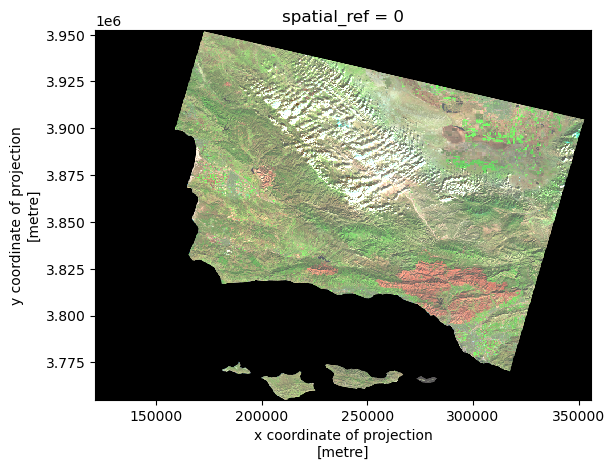

In [20]:
# Select the false color bands: SWIR, NIR, and Red. Then make it an array
landsat_false = landsat[ ['swir22','nir08','red'] ].to_array()
# Plot the False Color Image
landsat_false.plot.imshow(robust = True)

## Plot the Land Cover Data
Now that we have cleaned and wrangled all of the data, we are ready to make the final plot. It is important to remember that there are 4 main steps in making a more complicated visualizations with matplotlib.pyolot
1. Create the empty figure by defining the figure and axis
2. Add on the layers of data
3. Customize the non-data related features of the graph
4. Show the plot

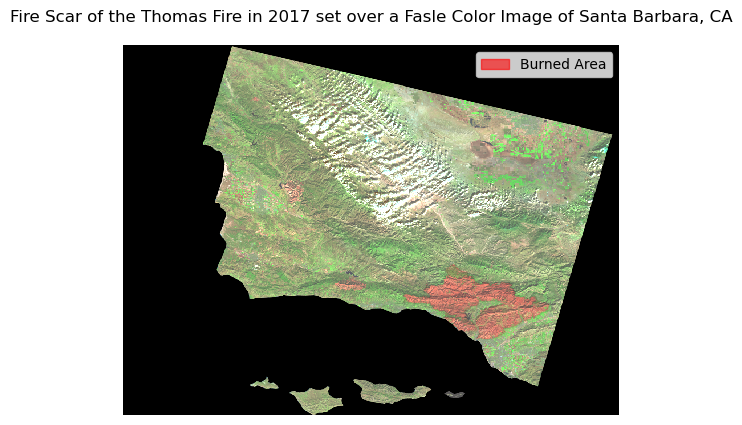

In [26]:
#----------STEP 1: Create Empty Figure---------------
# Create the Figure and Axis
fig, ax = plt.subplots()

#---------STEP 2: Add in the data Layers-------------
#Plot the Calfire Dataset
calfire.plot(ax=ax, #set the axis
             color='red', #Change the fill color
             alpha = 0.1, #Change the transparency of the layer
             edgecolor='black') #Change the edge color
#Plot the Landsat Data
landsat_false.plot.imshow(ax = ax, robust = True)

#---------STEP 3: Customize the figure features-------
#Add a figure title
ax.set_title('Fire Scar of the Thomas Fire in 2017 set over a Fasle Color Image of Santa Barbara, CA')
#Turn the Axes off
ax.axis('off')
#Add a figure legend
fire_scar = mpatches.Patch(color='red', alpha = 0.6, label='Burned Area')
ax.legend(handles=[fire_scar])

#--------STEP 4: Show the Plot-------------------------
plt.show()